In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ANEMO import read_edf
from ANEMO import ANEMO

# extracting data and doing the fit on velocity

In [2]:
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

# Residu!

In [3]:
list_fct = ['velocity_exp', 'velocity_sigmo', 'velocity_line']

demi_four, demi_freq = {}, {}
four, freq_four = {}, {}

for f in [demi_four, demi_freq, four, freq_four] :
    for fct in list_fct :
        f[fct] = []
N_freq = 1301
for s in range(len(sujet)) :
    print(sujet[s], end=' ')
    
    param = {}
    for fct in list_fct :
        if fct == 'velocity_exp' : name_file = 'velocity'
        else :                     name_file = fct
        
        with open('parametre/param_Fit_%s_fct_%s_filt_velo_30.pkl'%(sujet[s], name_file), 'rb') as fichier :
            param[fct] = pickle.load(fichier, encoding='latin1')
        
        file = 'data/enregistrement_%s_%s.asc'%(sujet[s], time[s])
        data = read_edf(file, 'TRIALID')
        
        with open('data/enregistrement_%s_%s.pkl'%(sujet[s], time[s]), 'rb') as fichier:
            param_exp = pickle.load(fichier, encoding='latin1')
        A = ANEMO(param_exp)
        
        
        for block in range(3) :
            for trial in range(200):
                arg = A.arg(data[trial+block*param_exp['N_trials']], trial=trial, block=block)
                
                start = arg.TargetOn-arg.t_0
                debut, fin = param[fct]['before_sacc'], param[fct]['after_sacc']
                
                res = param[fct]['goodness_of_fit']['residual'][block][trial]
                
                residu = np.zeros(len(arg.trackertime)-param[fct]['time_sup'])
                
                lala = [] #np.zeros(len(arg.trackertime)-param[fct]['time_sup'])
                for s in range(len(arg.saccades)):
                    for t in np.arange((arg.saccades[s][0]-arg.t_0-debut), (arg.saccades[s][1]-arg.t_0+fin)) :
                        lala.append(t)
                
                t_s = 0
                for t in range(len(arg.trackertime)-param[fct]['time_sup']) :
                    if t in lala :
                        residu[t] = np.nan
                        t_s = t_s+1
                    else :
                        if t-t_s < len(res) :
                            residu[t] = res[t-t_s]
                
                residu = residu[start-700:start+(N_freq-700)]
                # -----------------------------------------------------------------------------
                
                ms = 1000.0                         # taux d'échantillonnage
                dt = 1.0/ms                         # intervalle d'échantillonnage
                n = len(residu)                     # longueur du residu
                
                k, T = np.arange(n), n/ms
                frq = k/T                           # gamme de fréquence de deux côtés
                
                N = range(N_freq//2 +1)             # range(int(n/2))

                frq = frq[N]                        # une gamme de fréquence latérale
                freq = np.fft.fftfreq(N_freq, d=dt)

                residu = np.ma.masked_array(residu, mask=np.isnan(residu)).compressed()
                
                fourier = np.fft.fft(residu, n=N_freq)/n      # fft informatique et normalisation

                # -----------------------------------------------------------------------------
                demi_four[fct].append((abs(fourier[N])).tolist())
                four[fct].append(fourier.tolist())
                demi_freq[fct].append(frq.tolist())
                freq_four[fct].append(freq.tolist())

AM BMC CS DC FM IP LB OP RS SR TN YK 

In [4]:
for fct in list_fct :
    for f in [demi_four, demi_freq, four, freq_four] :
        print(fct, np.shape(f[fct]))

velocity_exp (7200, 651)
velocity_exp (7200, 651)
velocity_exp (7200, 1301)
velocity_exp (7200, 1301)
velocity_sigmo (7200, 651)
velocity_sigmo (7200, 651)
velocity_sigmo (7200, 1301)
velocity_sigmo (7200, 1301)
velocity_line (7200, 651)
velocity_line (7200, 651)
velocity_line (7200, 1301)
velocity_line (7200, 1301)


## Fit Residu Power Law

In [5]:
from lmfit.models import PowerLawModel

/usr/local/lib/python3.6/dist-packages/lmfit/lineshapes.py:397: RuntimeWarning: divide by zero encountered in power
  return amplitude * x**exponent


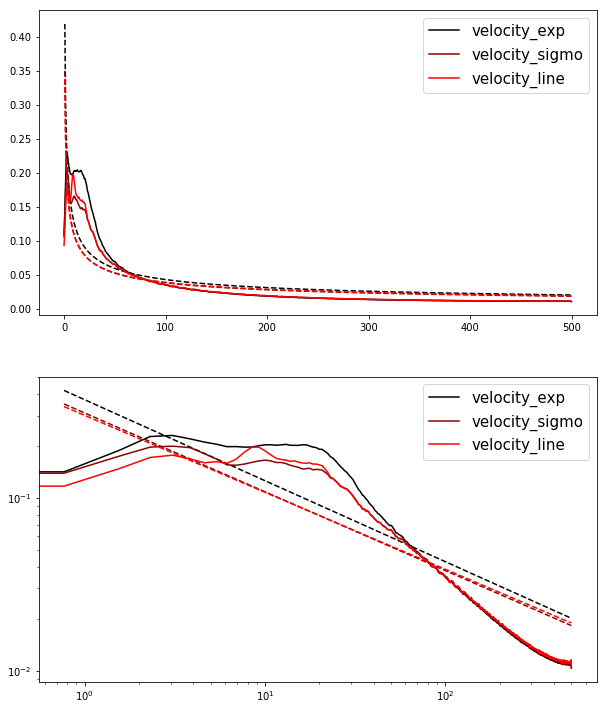

In [6]:
fig_width= 10
fig, axs = plt.subplots(2, 1, figsize=(fig_width*1, 2*(fig_width)/1.6180))

c = ['k', 'darkred', 'r']

for i, fct in enumerate(list_fct) :

    mean_demi_four = np.nanmean(demi_four[fct], 0)

    mod = PowerLawModel()

    pars = mod.guess(mean_demi_four, x=np.arange(len(mean_demi_four)))
    out = mod.fit(mean_demi_four, pars, x=np.arange(len(mean_demi_four)), nan_policy='omit')
    
    
    axs[0].plot(np.mean(demi_freq[fct], 0), np.mean(demi_four[fct], 0), c[i], label=fct)
    axs[0].plot(np.mean(demi_freq[fct], 0),out.best_fit, c[i], ls='--')

    axs[1].loglog(np.mean(demi_freq[fct], 0), np.mean(demi_four[fct], 0), c[i], label=fct)
    axs[1].loglog(np.mean(demi_freq[fct], 0), out.best_fit, c[i], ls='--')
axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15);